In [1]:
import itertools
import math as m
import os 
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def read_input(graphfile):
    
    trip_data = open(graphfile,'r').read().split('\n')
    i = 0
    listOfGraphs = {}
    k = 0
    
    while(True):
        if "#" in trip_data[i]:
            i = i+1
            N = int(trip_data[i])
            edges = list()
            while(True):
                i = i+1;
                if "#" in trip_data[i]:
                    break;
                if "" == trip_data[i]:
                    break;
                line = trip_data[i].split(" ")
                edges.append((line[0],line[1],line[2]))
                if i >= len(trip_data)-1:
                    break;
            G = {'Nodes':N,'list of edges': edges}
            listOfGraphs[k] = G
            k +=1 
        if i >= len(trip_data)-1:
                    break; 

    return listOfGraphs;
    

In [3]:
def flowMultipleDecomposition(data,K):
    
    
    #libraries
    import gurobipy as gp
    from gurobipy import GRB
    
    # calculate the minimal flow decomposition based on such graph
    V = data['vertices']
    E = data['edges']
    f = data['flows']
    W = data['maxFlow']
    S = data['sources']
    D = data['targets']
    AD_in = data['adj_in']
    AD_out = data['adj_out']

    try:
        
        #create extra sets
        T = [(i,j,k) for (i,j) in E for k in range(0,K)]
        SC = [k for k in range(0,K)]
        ST = [(i,k) for i in V for k in range(0,K)]
        
        # Create a new model
        model = gp.Model("MFD")
        model.Params.LogToConsole = 0

        # Create variables
        x = model.addVars(T,vtype=GRB.BINARY, name="x")
        w = model.addVars(SC,vtype=GRB.INTEGER, name="w",lb=0)
        z = model.addVars(T,vtype=GRB.CONTINUOUS, name="z",lb=0)
        c = model.addVars(ST,vtype=GRB.BINARY, name="c")
        t = model.addVars(ST,vtype=GRB.CONTINUOUS,name="t")
        
    
        model.setObjective(GRB.MINIMIZE)
       
        # flow conservation
        for k in range(0,K):
            for i in V:
                if i in S:
                    model.addConstr(sum(x[i,j,k] for j in AD_out[i])<= 1) 
                if i in D:
                    model.addConstr(sum(x[j,i,k] for j in AD_in[i]) <= 1)
                if i not in S and i not in D:
                    model.addConstr(sum(x[i,j,k] for j in AD_out[i]) - sum(x[j,i,k] for j in AD_in[i]) == 0)

        
        # flow balance
        for (i,j) in E:
            model.addConstr(f[i,j] == sum(z[i,j,k] for k in range(0,K)))

        # linearization
        for (i,j) in E:
            for k in range(0,K):
                model.addConstr(z[i,j,k] <= W*x[i,j,k])
                model.addConstr(w[k] - (1 - x[i,j,k])*W <= z[i,j,k])
                model.addConstr(z[i,j,k] <= w[k])
     
        # order sequence
        for (i,j) in E:
            for k in range(0,K):
                model.addConstr(t[j,k] >= t[i,k] + 1 + (len(V) - 1)*(x[i,j,k] - 1 - c[i,k]))
                
        # cycle and path definitions
        for k in range(0,K):
            model.addConstr(sum(x[i,j,k] for i in S for j in AD_out[i]) + sum(c[i,k] for i in V) <= 1)
        
        # objective function
        model.optimize()
        
        model.write("simple.lp")
        
        w_sol = [0]*len(range(0,K))
        x_sol = {}
        paths = [list() for i in range(0,K)]
    
        
        if model.status == GRB.OPTIMAL:
            data['message'] = 'solved'
            data['runtime'] = model.Runtime;

            for v in model.getVars():
                if 'w' in v.VarName:
                    for k in range(0,K):
                        if str(k) in v.VarName:
                            w_sol[k] = v.x
                
                if 'x' in v.VarName:          
                    for (i,j,k) in T:
                        if str(i)+","+str(j)+","+str(k) in v.VarName:
                            x_sol[i,j,k] = v.x
                
            for(i,j,k) in T:
                if x_sol[i,j,k] == 1:
                    paths[k].append((i,j))
            
            data['weights'] = w_sol
            data['solution'] = paths
        
        if model.status == GRB.INFEASIBLE:
            data['message'] = 'unsolved'
        
    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')
    
    return data;
    

In [4]:
def FD_Algorithm(data):
    
    listOfEdges = data['edges']
    solutionMap = data['graph']
    solutionSet = {}
    Kmin = data['minK']
    solutionWeights = 0

    for i in range(1,len(listOfEdges)+1):
        data = flowMultipleDecomposition(data,i)
        if data['message'] == "solved":
            solutionSet = data['solution']
            solutionWeights = data['weights']
            break;

    
    # display solutions
    colors = ['red','green','yellow','cyan','purple','violet']
    edges = list(solutionMap.edges())
    edges_colors = [0]*len(edges)
    edges_weights = [0]*len(edges)
    
    for i in range(0,len(solutionSet)):
        for k in range(0,len(edges)):
            edges_colors[k] = "beige"
        plt.figure()
        my_pos = nx.spring_layout(solutionMap, seed = 100)
        
        for j in solutionSet[i]:
            if j in edges:
                edges_colors[edges.index(j)] = "red"
                edges_weights[edges.index(j)] = 2
        
            
        print("W:",solutionWeights[i])
        nx.draw(solutionMap, pos = my_pos,edge_color=edges_colors,with_labels=True, node_color='lightblue', node_size=400, linewidths= edges_weights, font_size=15)
        plt.show()
        
    return data

In [5]:
def SolveInstances(Graphs,outfile):
    
    fp = open(outfile,'w+')
    
    for i in range(0,1): 
        
        f = {}
        Edges = set()
        V = set()
        listOfEdges = Graphs[i]['list of edges']
        for k in range(0,len(listOfEdges)):
            (a,b,c) = (listOfEdges[k])
            Edges.add((a,b))
            V.add(a)
            V.add(b)
            f[a,b] = int(float(c))
            
        
        # creation of graphs
        G = nx.DiGraph()
        G.add_edges_from(Edges,weights = f)
        G.add_nodes_from(V)
        
        # creation of adjacent matrix
        AD_in = {}
        AD_out = {}
        
        for v in V:
            setAdj = set()
            for (i,j) in list(G.out_edges(v)):
                if i != v:
                    setAdj.add(i)
                if j != v:
                    setAdj.add(j)
            
            AD_out[v] = list(setAdj)
            
            setAdj = set()
            for (i,j) in list(G.in_edges(v)):
                if i != v:
                    setAdj.add(i)
                if j != v:
                    setAdj.add(j)
            
            AD_in[v] = list(setAdj)
        
        
        # calculating source, sinks and max flows
        S = [x for x in G.nodes() if G.out_degree(x)>=1 and G.in_degree(x)==0]
        D = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)>=1]
        maxW = max(f.values())

        
        data = {'edges' : Edges,
                'flows' : f,
                'vertices' : V,
                'graph' : G,
                'Kmax' : len(Edges),
                'weights' : {},
                'sources': S,
                'targets': D,
                'message': {},
                'solution': 0,
                'maxFlow': maxW,
                'adj_in': AD_in,
                'adj_out': AD_out,
                'minK': 2,
                'runtime': 0,
        }
        
        data = FD_Algorithm(data)        
        
        print(len(data['weights']),data['runtime'],file=fp)
        
    
    return 0

Academic license - for non-commercial use only - expires 2022-10-10
Using license file /Users/cunhfern/gurobi.lic
W: 2.0


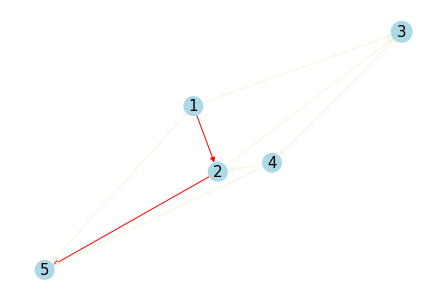

W: 2.0


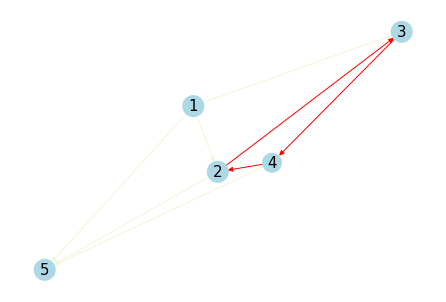

W: 2.0


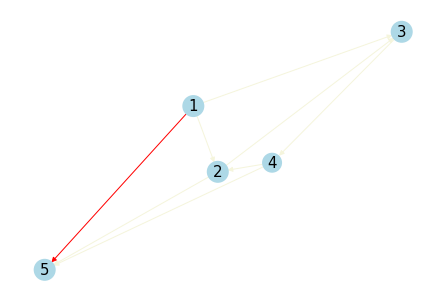

W: 3.0


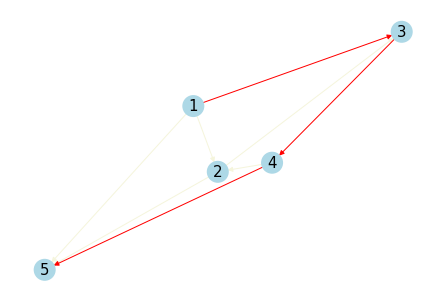

Done


In [6]:
path = "../Example/Cycle/"
text_files = [f for f in os.listdir(path) if f.endswith('.graph')]
outputfile = "results_cycle_gurobi.txt"

for i in range(0,len(text_files)):    
    filename = text_files[i]
    data = read_input(''.join([path,filename]))
    data = SolveInstances(data,outputfile)
    
print("Done")